# Data Eng: Week 3 Practical

In this practical you will modify the pipeline from the practical of week 2 to read an additional data source from a NoSQL database. You will also modify the transform step to perform more complex transformations. You will also modify the load step to write out your resulting data to a SQLite database.

---

## Overview

In addition to our existing data sources (`users` and `orders`), we now have a third data source `stores`. It is a json file stored in a NoSQL database called [TinyDB](https://tinydb.readthedocs.io/en/latest/) - we will create this local database from within the notebook.

You will notice that our `orders` source contains a field called `store_id`. The `stores` data contains information about each of our stores.

In Week 2, we wanted a view of orders per day, broken down by gender. We would now like to add a more detailed breakdown - the number of orders per day, broken down by province, store, gender and loyalty customers. By loyalty customers, we want to know whether the customer joined the store's loyalty program in the year of the purchase (context: in addition to personalised offers and discounts, customers receive a voucher at the end of the first year of joining the loyalty program, based on all the purchases done in that year).

We still want to extract data for a particular day, so that this job may be sheduled/orchestrated in future.

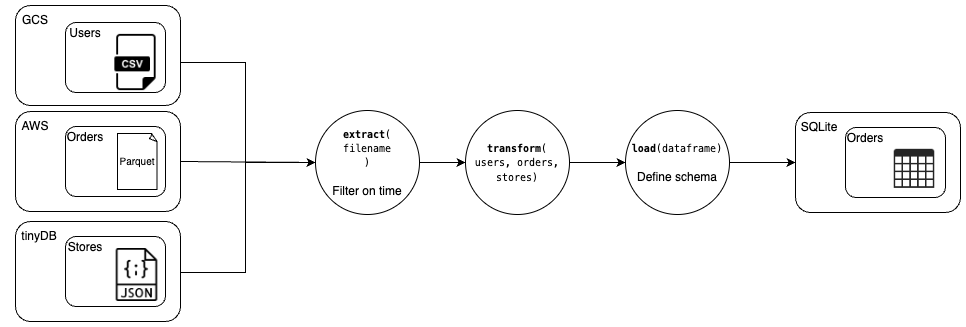
  

**Note**:
  * You must process the data in memory and not by writing it to the disk of this notebook first.


In [ ]:
# setup  your python environment by installing the necessary packages

! pip install --quiet pandas boto3 s3fs pyarrow
! pip install tinydb

In [ ]:

#
# Creates stores.json as local TinyDB and inserts store data
# DO NOT EDIT
#

from tinydb import TinyDB, Query
# Create or load the TinyDB database (the file will be saved locally in Colab's environment)
db = TinyDB('stores.json')

# Insert store data
stores_data = {
    "1": {
        "name": "Downtown Grocery",
        "address": "123 Main St, Somerset West, Western Cape",
        "hours": "8am – 9pm"
    },
    "2": {
        "name": "Westside Market",
        "address": "123 Dorp St, Stellenbosch, Western Cape",
        "hours": "7am – 10pm"
    },
    "3": {
        "name": "DeWaterGat Market",
        "address": "341 Kerk St, Port Elizabeth, Eastern Cape",
        "hours": "9am – 6pm"
    },
       "4": {
        "name": "The Diamond Market",
        "address": "632 Carters rd, Kimberley, Northern Cape",
        "hours": "9am – 5pm"
    },
       "5": {
        "name": "East London Market",
        "address": "478 Wilsonia St, East London, Eastern Cape",
        "hours": "8am – 6pm"
    }

}

# Insert the stores data into the database
for store_id, store_info in stores_data.items():
    db.insert({'store_id': store_id, **store_info})


In [ ]:
# import the python packages
import pandas as pd

# import package to read from google cloud storage
from google.cloud import storage
from io import StringIO

## Extract
Our gcs_extract() function remains the same as in Week 2.

In [ ]:
def gcs_extract(bucket_name: str, filename: str,  delimiter: str=',') -> pd.DataFrame:
  """
  extract data from a csv file in a GCS bucket and structure it into a pandas dataframe

  Args:
     bucket_name (str): name of the bucket
     filename (str): name of the file
     delimiter (str): default ','

  Return:
     pandas.DataFrame: A pandas dataframe with header as defined by the csv file
  """

  try:
    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name=bucket_name)
    blob = bucket.blob(filename)
    data = blob.download_as_text()
    # Use StringIO to read the string data into a pandas DataFrame
    df = pd.read_csv(StringIO(data))
    return df
  except FileNotFoundError:
    # Handle the case where the file is not found in GCS
    print(f"Error: File '{filename}' not found.")
    return None

In [ ]:
df_users = gcs_extract('bdt-beam','users_v.csv')
df_users.head()

Our s3_extract() function remains the same as in Week 2.

In [ ]:
def s3_extract(bucket_name: str, filename: str) -> pd.DataFrame:
  """
  extract data from a file in an S3 bucket and structure it into a pandas dataframe

  Args:
     bucket_name (str): name of the bucket
     filename (str): name of the file

  Return:
     pandas.DataFrame: A pandas dataframe with header as defined by the csv file
  """

  try:
    s3_path =  's3://' + bucket_name + '/' + filename
    # Read the Parquet file into a pandas DataFrame and filter for 2000-01-02 only
    df = pd.read_parquet(s3_path, filters=[('date_purchased', '==', '2000-01-02')])
    return df
  except FileNotFoundError:
    # Handle the case where the file is not found in S3
    print(f"Error: File '{filename}' not found.")
    return None

In [ ]:
df_orders = s3_extract('dev-training-analytics','df_orders.parquet')
df_orders.head()

Complete the extract function for the stores 'table'.

The required json file (stores.json) is stored in a TinyDB.

_HINT: To retrieve all data in a TinyDB, you can use the all() function - see [tinydb tutorial](https://www.tutorialspoint.com/tinydb/tinydb_all_query.htm).
You may also need to add some additional packages to your import cell at the top of the notebook._

In [ ]:
###
# this function is to be completed by the student
##
def tinydb_extract(database_name: str) -> pd.DataFrame:
  """
  extract data from a file in a TinyDB instance and structure it into a pandas dataframe

  Args:
     database_name (str): name of the database
  Return:
     pandas.DataFrame: A pandas dataframe with header as defined by the database
  """

  try:
    ## --- begin: student to complete subsequent code
    # Load the stores data from TinyDB

    ### --- end
  except FileNotFoundError:
    # Handle the case where the file is not found in S3
    print(f"Error: File '{database_name}' not found.")
    return None

In [ ]:
## --- begin: student to complete subsequent code

# Complete the function call to read orders.csv into a dataframe and check the result
df_stores = tinydb_extract()
df_stores.head()
# --- end:

## Transform

Update the transform() function to incorporate all three sources, and transform the data to return the daily order count, broken down by province, store, gender and loyalty customers (whether or not the customer joined the loyalty program in the same year as the purchase).

_HINT: You will need to extract the province from the address in stores data before joining onto orders - see [stackoverflow](https://www.geeksforgeeks.org/how-to-break-up-a-comma-separated-string-in-pandas-column/). You can apply this to your dataframe using a lambda function - see [applying lambda functions](https://www.geeksforgeeks.org/applying-lambda-functions-to-pandas-dataframe/).
You will also need to determine whether a customer qualifies for the loyalty customer program and define a new field - see [stackoverflow](https://stackoverflow.com/questions/49228596/pandas-case-when-default-in-pandas).
You may also need to perform some data type conversions and add some additional packages to your import cell at the top of the notebook._

In [ ]:
def transform(users: pd.DataFrame, orders: pd.DataFrame, stores: pd.DataFrame) -> pd.DataFrame:
  """
  Take three dataframes, and produce a dataset

  Args:
     users: a dataframe of user information
     orders: a dataframe of user orders
     stores: a dataframe of store information

  Return:
     pandas.DataFrame: A pandas dataframe with header as defined by user
     requirements
  """
  ## --- begin: student to complete subsequent code

  ## --- end:
  return df.reset_index()



In [ ]:
## --- begin: student to complete subsequent code

# Complete the function call to read orders.csv into a dataframe and check the result
df_transform = transform()
df_transform.head()
# --- end:

### Load

Update the load() function to create a local SQLite database (`local_sqlite_database.db`) and write out the resulting dataframe as a table (`sales_aggregated`).

_HINT: You can use python's sqlite3 package to create and connect to a SQLite instance. Load your data to the database - see [creating a SQLite DB](https://drlee.io/crafting-a-database-in-google-colab-a-beginners-guide-ccfb5e3ba22d) and [pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_sql.html). You may also need to add some additional packages to your import cell at the top of the notebook._


In [ ]:
def load(transformed: pd.DataFrame, database_name: str, table_name: str) -> None:
  """
  Write the dataframe to a local sqlite db

  Args:
    transformed: a dataframe with columns ['date_purchased','province','store_id', 'gender', 'loyalty', 'total_purchases']
    database_name: name for the local SQLite DB you are creating
    table_name: name of the table you are loading the data to
  Return:
    None
  """
  try:
    ## --- begin: student to complete subsequent code

    ## --- end:
    print(f"DataFrame successfully written to '{table_name}' in database '{database_name}'.")
  except Exception as e:
    # Handle any errors that might occur during writing
    print(f"Error writing DataFrame to databse: {e}")

In [ ]:
# Execute your load() function to load your data into the SQLite database
load(df_transform, 'local_sqlite_database.db', 'sales_aggregated')

## Pipeline

Run your pipeline end to end

Expected output (use `!head df_transform`):


| date_purchased | province | store_id | gender | loyalty | total_purchases |
| ------ | ------ | ------ | ------ | ------ | ------ |
| 2000-01-02 | Eastern Cape | 3 | male | False | 2 |
| 2000-01-02 | Eastern Cape | 5 | female | False | 1 |
| 2000-01-02 | Eastern Cape | 5 | male | False | 2 |
| 2000-01-02 | Northern Cape | 4 | male | False | 2 |
| 2000-01-02 | Northern Cape | 4 | male | True | 1 |
| 2000-01-02 | Western Cape | 1 | female | False | 1 |
| 2000-01-02 | Western Cape | 1 | male | True | 1 |
| 2000-01-02 | Western Cape | 2 | female | False | 2 |
| 2000-01-02 | Western Cape | 2 | male | False | 2 |




Expected output of pipeline (when running your load function)
```
DataFrame successfully written to 'sales_aggregated' in database.

```

In [ ]:
df_users = gcs_extract()
df_orders = s3_extract()
df_stores = tinydb_extract()
df_transform = transform()
load()
